In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df=pd.read_csv("train_MpHjUjU.csv")

In [3]:
df.head(2)

,MMM-YY,Emp_ID,Age,Gender,City,Education_Level,Salary,Dateofjoining,LastWorkingDate,Joining Designation,Designation,Total Business Value,Quarterly Rating
0,2016-01-01,1,28,Male,C23,Master,57387,2015-12-24,NaN,1,1,2381060,2
1,2016-02-01,1,28,Male,C23,Master,57387,2015-12-24,NaN,1,1,-665480,2


Changing time to timestamp for better control.

In [4]:
from datetime import datetime, date
df['Time'] = list(map(lambda x: datetime.strptime(x, '%Y-%m-%d'), df['MMM-YY']))

In [5]:
df['Dateofjoining']=list(map(lambda x: datetime.strptime(x, '%Y-%m-%d'), df['Dateofjoining']))

Using 'Left' boolean value for better understanding, of who left and who stayed(0:Still Present, 1:Left/Leaving)

In [6]:
df['Left']=df.apply(lambda x: 0 if type(x['LastWorkingDate'])==float else 1, axis=1)

To estimate the total duration the employee has been with the organization, by subtracting the 'LastWorkingDate' and 'Dateofjoining'.(Note: I have used default date of last day of 2017 "31st Dec,2017" for employees marked as retained)

In [7]:
dr=[]
for d in df['LastWorkingDate'].index:
    if type(df['LastWorkingDate'][d]) is not float:
        dr.append(str(datetime.strptime(df['LastWorkingDate'][d], '%Y-%m-%d')-df['Dateofjoining'][d]))
    else:
        dr.append(str(datetime.strptime('2017-12-31', '%Y-%m-%d')-df['Dateofjoining'][d]))
#to convert duration list from datatype timestamp to integer
dur=[]
for i in dr:
    dur.append(int(i.replace(' days 00:00:00',"")))

In [8]:
df['Duration']=dur

Creating a dataset with all employee details

In [9]:
groupByID=df.groupby(['Emp_ID'])

In [10]:
#grouped by Employee ID
data=pd.DataFrame(groupByID.sum()[['Total Business Value','Left']])

In [11]:
data[['Duration','Highest_Ed','Gender','City','Salary']]=df[['Duration','Education_Level','Gender','City','Salary']]

In [12]:
#taking the last Quarter Ratings only
data['LastQuarterRating']=0
data['LastQuarterRating']=list(map((lambda x: df['Quarterly Rating'][df[df['Emp_ID']==x].last_valid_index()]),data.index))

In [13]:
#taking last assigned desination for the employee
data['Designation']=0
data['Designation']=list(map((lambda x: df['Designation'][df[df['Emp_ID']==x].last_valid_index()]),data.index))

In [14]:
data['Highest_Ed'].value_counts()

Bachelor    842
College     777
Master      762
Name: Highest_Ed, dtype: int64

Creating a numerical value for each Education Level 

In [15]:
highED=[]
highED=list(map(lambda x:1 if x=='College' else(2 if x=='Bachelor' else 3),data['Highest_Ed']))
data['Ed_Level']=highED

In [16]:
#Assigning last know age at the end of 2017
data['Age']=list(map(lambda x: int(df[df['Emp_ID']==x].nlargest(n=1,columns='Age',keep='last')['Age']),data.index))

In [17]:
data['City'].unique()

array(['C23', 'C7', 'C13', 'C9', 'C11', 'C2', 'C19', 'C26', 'C20', 'C17',
       'C29', 'C10', 'C24', 'C14', 'C6', 'C28', 'C5', 'C18', 'C27', 'C15',
       'C8', 'C25', 'C21', 'C1', 'C4', 'C3', 'C16', 'C22', 'C12'],
      dtype=object)

<AxesSubplot:xlabel='City'>

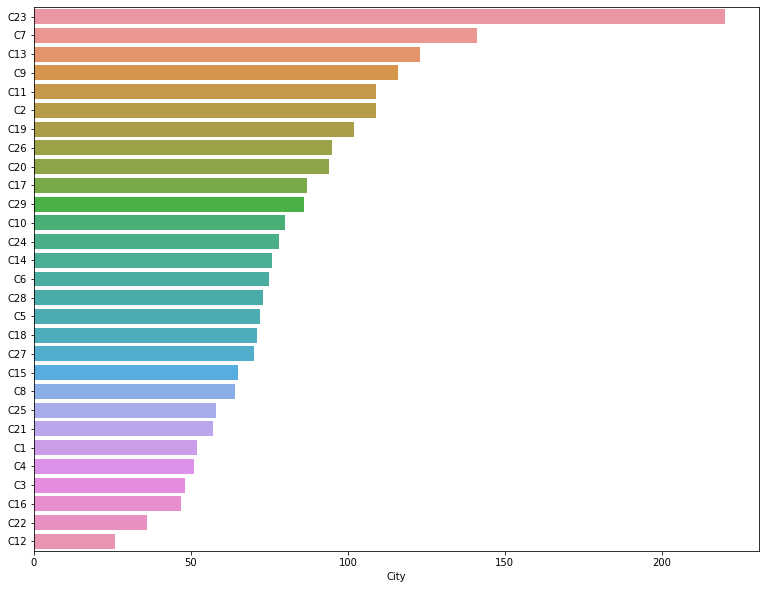

In [18]:
#to visulaize the demographic of the employees from a city
plt.figure(figsize=(13,10))
sns.barplot(x=data['City'].value_counts(),y=data['City'].unique(),orient='h')

<AxesSubplot:xlabel='Age', ylabel='Count'>

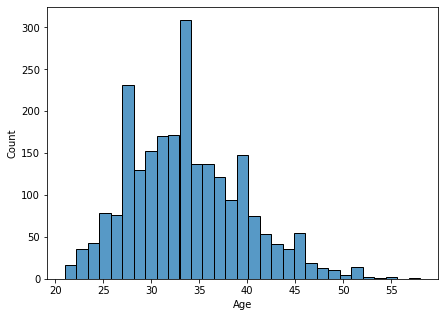

In [19]:
#to visulaize the age group of the employees from a city
plt.figure(figsize=(7,5))
sns.histplot(x=data['Age'])

<AxesSubplot:xlabel='Total Business Value', ylabel='Salary'>

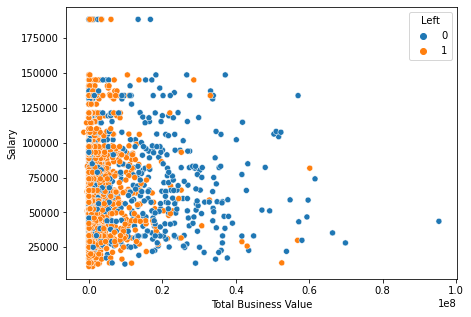

In [20]:
#to visulaize the relation between Salary and Business Value, in light of people who left and have still stayed
plt.figure(figsize=(7,5))
sns.scatterplot(x=data['Total Business Value'],y=data['Salary'],hue=data['Left'])

count    2.381000e+03
mean     4.586742e+06
std      9.127115e+06
min     -1.385530e+06
25%      0.000000e+00
50%      8.176800e+05
75%      4.173650e+06
max      9.533106e+07
Name: Total Business Value, dtype: float64

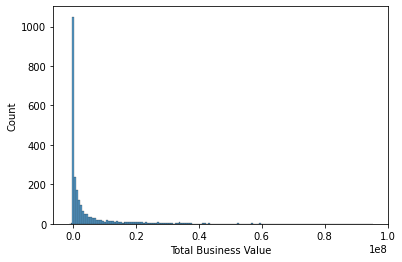

In [21]:
sns.histplot(x=data['Total Business Value'])
data['Total Business Value'].describe()

<AxesSubplot:xlabel='LastQuarterRating', ylabel='Salary'>

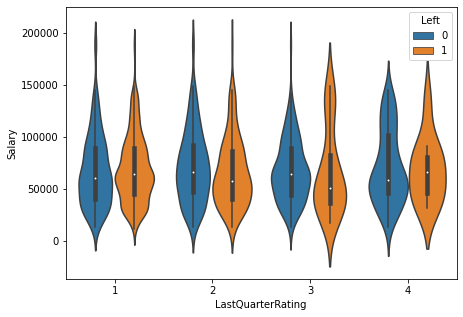

In [22]:
#to visulaize the relation between Salary and Last Quarter Rating, in light of people who left and have still stayed
plt.figure(figsize=(7,5))
sns.violinplot(x=data['LastQuarterRating'],y=data['Salary'],hue=data['Left'])

Trying to build a model using the dataset.

In [23]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

In [24]:
data['Male']=pd.get_dummies(data['Gender'])['Male']

In [25]:
data[data['City'].unique()]=pd.get_dummies(data['City'])

In [26]:
#Setting the input and the output values.
X=data.drop(['Highest_Ed','Gender','City','Duration','Left'],axis=1)
y=data['Left']

In [27]:
X_train,X_val,y_train,y_val=train_test_split(X,y,test_size=0.2,random_state=101)

In [28]:
#Using Logistic Regression Model
lR=LogisticRegression()

In [29]:
lR.fit(X_train,y_train)

LogisticRegression()

In [30]:
pred=lR.predict(X_val)

In [31]:
from sklearn.metrics import classification_report, confusion_matrix, f1_score

In [32]:
print(classification_report(y_val,pred))

              precision    recall  f1-score   support

           0       0.69      0.35      0.47       156
           1       0.75      0.92      0.82       321

    accuracy                           0.74       477
   macro avg       0.72      0.64      0.65       477
weighted avg       0.73      0.74      0.71       477



In [33]:
print(confusion_matrix(y_val,pred))

[[ 55 101]
 [ 25 296]]


In [34]:
f1_score(y_val,pred)

0.8245125348189416

In [35]:
test=pd.read_csv('test_hXY9mYw.csv')

In [36]:
test['Emp_ID']

0       394
1       173
2      1090
3       840
4       308
       ... 
736    2134
737    2255
738     448
739    1644
740     624
Name: Emp_ID, Length: 741, dtype: int64

In [37]:
pred_y=[]
for i in test['Emp_ID']:
             pred_y.append(int(lR.predict(X[X.index==i])))

In [38]:
print(pred_y)

[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 

In [39]:
test['Target']=pred_y

In [40]:
test['Target'].value_counts()

1    481
0    260
Name: Target, dtype: int64

In [41]:
test.set_index('Emp_ID')

,Target
Emp_ID,
394,0
173,0
1090,0
840,1
308,0
...,...
2134,0
2255,0
448,0


In [43]:
#test.to_csv('Submission2.csv')